<a href="https://www.kaggle.com/code/averma111/pytorch-ps3e20-optuna?scriptVersionId=138541039" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [102]:
%%capture 
!pip install optuna

In [103]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
from tqdm.notebook import tqdm
import optuna
from optuna.trial import TrialState
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pickle
from optuna import trial
warnings.filterwarnings('ignore')
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

In [104]:
class DataAcquisition:
    
    def __init__(self):
        self.X_train=None
        self.X_val=None
        self.y_train=None
        self.y_val=None
        self.X_test= None
    
    def prepare_data(self):
        path = '/kaggle/input/playground-series-s3e20/train.csv'
        df = pd.read_csv(
            path, 
            sep=',', 
            infer_datetime_format=True, 
            low_memory=False
        )
        
        X = df.copy()
        return X
    
    def prepare_data_test(self):
        path = '/kaggle/input/playground-series-s3e20/test.csv'
        df = pd.read_csv(
            path, 
            sep=',', 
            infer_datetime_format=True, 
            low_memory=False
        )
        
        X = df.copy()
        return X
    
    
    def new_features(self,df):
        pass
    
    
    def summary(self,text, df):
        print(f'{text} shape: {df.shape}')
        summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
        summ['null'] = df.isnull().sum()
        summ['unique'] = df.nunique()
        summ['min'] = df.min()
        summ['median'] = df.median()
        summ['max'] = df.max()
        summ['mean'] = df.mean()
        summ['std'] = df.std()
        summ['duplicate'] = df.duplicated().sum()
        return summ
    
    def _get_numerical_features(self,df):
        numerical_feature = df.select_dtypes(include=['float64'])
        return numerical_feature
    
    
    def plot_numerical_histogram(self,df):
        fig, ax = plt.subplots(5, 15, figsize = (5, 15), dpi = 90)
        ax = ax.flatten()

        for i, column in enumerate(self._get_numerical_features(df)):
            sns.histplot(df[column], ax=ax[i], color='r')
    
            ax[i].set_title(f'{column} Distribution', size = 5)
            ax[i].set_xlabel(None)
            ax[i].set_ylabel(None)
        fig.suptitle('Distribution of Numerical Feature', fontsize = 8)
        plt.tight_layout()
        
        
    def show_correlation(self,dataset, column_name,cmap):
        corr = dataset.corr(method = 'kendall')
        plt.figure(figsize = (10, 10), dpi = 90)
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(corr, mask = mask, cmap = cmap, annot = True, annot_kws = {'size' : 12})
        #plt.title(f'{column_name} Dataset Correlation Matrix\n', fontsize = 15, weight = 'bold')
        plt.show()
    
    
    def preprocessing(self,df):
        #df.fillna(df[df.columns].mean(),axis=1,inplace=True)
        X = df.copy()
        X['year'] =  LabelEncoder().fit_transform(X['year'])
        X['week_no'] =  LabelEncoder().fit_transform(X['week_no'])
        X = X.loc[:, X.columns!='ID_LAT_LON_YEAR_WEEK']
        y = X['emission']
        X.drop(columns=['emission'],axis=1,inplace=True)
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.25, shuffle=False
        )
        self.X_train=X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        return  self.X_train,self.X_val,self.y_train,self.y_val
        
    def preprocessing_test(self,df):
        df.fillna(df[df.columns].mean(),axis=1,inplace=True)
        X = df.copy()
        X['year'] =  LabelEncoder().fit_transform(X['year'])
        X['week_no'] =  LabelEncoder().fit_transform(X['week_no'])
        X = X.loc[:, X.columns!='ID_LAT_LON_YEAR_WEEK']
        y = X['ID_LAT_LON_YEAR_WEEK']
        X.drop(columns=['ID_LAT_LON_YEAR_WEEK','ID_LAT_LON_YEAR_WEEK'],axis=1,inplace=True)
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.25, shuffle=False
        )
        self.X_test=X_train
        return  self.X_test
    
        
acq = DataAcquisition()

train_df = acq.prepare_data()
test_df = acq.prepare_data_test()

In [105]:
train_df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [106]:
test_df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022,0,NaN,NaN,NaN,NaN,NaN,...,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,...,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,...,34133.080469,8984.795703,39006.093750,7984.795703,10.753179,0.267130,39.087361,45.936480,-144.784988,26.743361
3,ID_-0.510_29.290_2022_03,-0.51,29.29,2022,3,0.000350,0.696917,0.000243,0.201028,72.169566,...,50854.991076,6014.724059,57646.368368,5014.724115,11.764556,0.304679,-24.465127,42.140419,-135.027891,29.604774
4,ID_-0.510_29.290_2022_04,-0.51,29.29,2022,4,-0.000317,0.580527,-0.000184,0.204352,76.190865,...,46594.685145,6849.280477,52896.541873,5849.280394,13.065317,0.284221,-12.907850,30.122641,-135.500119,26.276807


In [107]:
acq.summary('train',train_df)

train shape: (79023, 76)


,dtypes,null,unique,min,median,max,mean,std,duplicate
ID_LAT_LON_YEAR_WEEK,object,0,79023,ID_-0.510_29.290_2019_00,NaN,ID_-3.299_30.301_2021_52,NaN,NaN,0
latitude,float64,0,452,-3.299,-1.882000,-0.51,-1.891072,0.694522,0
longitude,float64,0,453,28.228,29.883000,31.532,29.880155,0.810375,0
year,int64,0,3,2019,2020.000000,2021,2020.000000,0.816502,0
week_no,int64,0,53,0,26.000000,52,26.000000,15.297155,0
...,...,...,...,...,...,...,...,...,...
Cloud_sensor_azimuth_angle,float64,484,78538,-102.739731,-12.673914,78.223037,-10.784832,30.374462,0
Cloud_sensor_zenith_angle,float64,484,78539,2.998873,41.119630,65.951248,40.436976,6.428216,0
Cloud_solar_azimuth_angle,float64,484,78539,-153.464211,-84.644352,-22.65317,-86.800583,37.837269,0
Cloud_solar_zenith_angle,float64,484,78539,10.818288,28.333630,42.060436,27.925981,4.403835,0


* There are nulls in 4 fields.
* Cloud_sensor_azimuth_angle ,Cloud_sensor_zenith_angle ,Cloud_solar_azimuth_angle ,Cloud_solar_zenith_angle.
* There are no duplicates.
* The year and week_no are categorical fields from 2019 to 2021 and 0 to 52.

<Axes: xlabel='emission', ylabel='Count'>

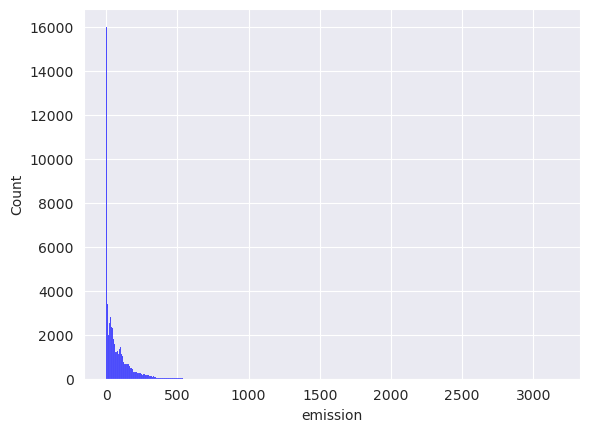

In [108]:
sns.histplot(train_df,x='emission',color='b')

In [109]:
#acq.plot_numerical_histogram(train_df)

In [110]:
#acq.show_correlation(train_df,train_df.columns,'flare')

In [111]:
X_train,X_val,y_train,y_val = acq.preprocessing(train_df)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(59267, 74) (19756, 74) (59267,) (19756,)


In [112]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [113]:
class Tensoroperations:
    
    def convert_to_torch(self,value):
        return torch.tensor(data=value,dtype=torch.float32,requires_grad=True)


    def get_dataloaders(self,dataset_type,batch,shuffle):
        if shuffle:
             return DataLoader(dataset=dataset_type, batch_size=batch, shuffle=True)
        else:
            return DataLoader(dataset=dataset_type, batch_size=batch,shuffle=False)


top = Tensoroperations()

In [114]:
class EmissionData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

X_data = top.convert_to_torch(X_train.values)
y_data = top.convert_to_torch(y_train.values)
X_val = top.convert_to_torch(X_val.values)
y_val = top.convert_to_torch(y_val.values)

train_data = EmissionData(X_data,y_data)
test_data = EmissionData(X_val,y_val)

In [115]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x,y):
        esp = 1e-6
        criterion = torch.nn.MSELoss()
        loss = torch.sqrt(criterion(x,y)) + esp
        return loss

In [116]:
def RegressionEmissionDataNet(trial,in_features,n_layers,dropout,n_output):
    
    layers = []
    fc_layer = in_features
    
    for i in range(n_layers):
        
        out_features = trial.suggest_int("n_units_l{}".format(i),2,in_features)
        layers.append(torch.nn.Linear(in_features, out_features))
        layers.append(torch.nn.ReLU())
        in_features = out_features

    layers.append(torch.nn.Linear(in_features, fc_layer)) 
    layers.append(torch.nn.ReLU())

    layers.append(torch.nn.Dropout(dropout))
    layers.append(torch.nn.Linear(fc_layer,n_output)) 
    
    return torch.nn.Sequential(*layers)

In [117]:
class Trainer:
    def train_net(self,trial, params,model):
        # Prepare DataLoader
        trainloader = top.get_dataloaders(EmissionData(X_data,y_data), batch=10, shuffle=True)
        testloader = top.get_dataloaders(EmissionData(X_val,y_val), batch=1, shuffle=False)
    
      # Define the loss function and optimizer
        loss_function = RMSELoss()
        optimizer = getattr(torch.optim, params['optimizer'])(model.parameters(), lr= params['learning_rate'], weight_decay=params['weight_decay'])
        # Run the training loop
        for epoch in range(0, 5): # 5 epochs at maximum
            total_test_loss = []
        # Iterate over the DataLoader for training data
            for i, data in enumerate(trainloader, 0):
                # Get and prepare inputs
                inputs, targets = data
                inputs, targets = inputs.float(), targets.float()
                targets = targets.reshape((targets.shape[0], 1))
                # Zero the gradients
                optimizer.zero_grad()
                # Perform forward pass
                outputs = model(inputs)
                # Compute loss
                loss = loss_function(outputs, targets)
                # Perform backward pass
                loss.backward()
                # Perform optimization
                optimizer.step()
            
            model.eval()
            with torch.no_grad():
                for i, data in enumerate(testloader, 0):
                    # Get and prepare inputs
                    inputs, targets = data
                    inputs, targets = inputs.float(), targets.float()
                    targets = targets.reshape((targets.shape[0], 1))
                
                    # # Perform forward pass
                    test_outputs = model(inputs)
                    test_loss = loss_function(test_outputs, targets)
                    total_test_loss.append(test_loss.item())
        

    # Process is complete.
    #save_best_model(trial,model)
        return total_test_loss
    
    
trainer = Trainer()

In [118]:
def objective(trial):

    # For TPESampler 
    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate',1e-5,1e-2), 
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'weight_decay': trial.suggest_loguniform('weight_decay',1e-5,1e-2),
              "n_layers" : trial.suggest_int("n_layers", 2,4),
              "dropout" : trial.suggest_float('dropout',0.1,0.5,step = 0.1)
              }
    
    model = RegressionEmissionDataNet(trial=trial,
            in_features= X_train.shape[1],
            n_layers=params['n_layers'] ,
            dropout=params['dropout'],
            n_output= 1).to(device)
    test_loss = trainer.train_net(trial,params,model) 
    return np.mean(test_loss)

In [ ]:
study = optuna.create_study(study_name='Pytorch-PS3E20',direction ="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials= 100,timeout=600)

    
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
best_trial = study.best_trial

print("Best trial:", best_trial)
print("  Value: ", best_trial.value)

print("Best Trail Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-08-01 05:56:41,946] A new study created in memory with name: Pytorch-PS3E20


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
best_model = RegressionFluxNet(trial=best_trial,
            in_features= X_train.shape[1],
            n_layers=best_trial.params['n_layers'] ,
            dropout=best_trial.params['dropout'],
            n_output= 1).to(device)
print(best_model)